In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import cv2
import kagglehub
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn import functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Downloading dataset...")
dataset_path = kagglehub.dataset_download('fareselmenshawii/large-license-plate-dataset')
print(f"Dataset downloaded to: {dataset_path}")

train_images_path = os.path.join(dataset_path, 'images/train')
train_labels_path = os.path.join(dataset_path, 'labels/train')
val_images_path = os.path.join(dataset_path, 'images/val')
val_labels_path = os.path.join(dataset_path, 'labels/val')
test_images_path = os.path.join(dataset_path, 'images/test')
test_labels_path = os.path.join(dataset_path, 'labels/test')


Using device: cuda


100%|██████████| 2.35G/2.35G [00:26<00:00, 96.2MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/fareselmenshawii/large-license-plate-dataset/versions/1


In [ ]:
# data already augmented but i added some more augmentations
transform_train = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAutocontrast(p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))
])

transform_val = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class LicensePlateDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, is_training=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.is_training = is_training

        
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        print(f"Found {len(self.image_files)} images in {image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        orig_width, orig_height = image.size
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        # extract yolo format
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])

                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_center + width / 2
                        y_max = y_center + height / 2

                        #values needed to be in rang of 0 to 1
                        x_min = max(0, min(1, x_min))
                        y_min = max(0, min(1, y_min))
                        x_max = max(0, min(1, x_max))
                        y_max = max(0, min(1, y_max))

                        boxes.append([x_min, y_min, x_max, y_max])

        if len(boxes) == 0:
            boxes.append([0, 0, 0, 0])

        if len(boxes) > 1:
            boxes = [boxes[0]]

        if self.transform:
            image = self.transform(image)

        boxes = torch.tensor(boxes, dtype=torch.float32)

        metadata = {
            'img_name': img_name,
            'orig_width': orig_width,
            'orig_height': orig_height
        }

        return image, boxes, metadata

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEResNeXtBlock(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, cardinality=32, stride=1, reduction=16):
        super(SEResNeXtBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.se = SEBlock(planes * self.expansion, reduction)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class BiFPNBlock(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(BiFPNBlock, self).__init__()

        self.num_levels = len(in_channels_list)

        # weighted fusion
        self.w1 = nn.Parameter(torch.ones(self.num_levels-1, dtype=torch.float32))
        self.w2 = nn.Parameter(torch.ones(self.num_levels-1, dtype=torch.float32))
        self.epsilon = 1e-4

        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, 1, 1, 0)
            for in_channels in in_channels_list
        ])

        self.td_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, 3, 1, 1, groups=out_channels),
                nn.Conv2d(out_channels, out_channels, 1, 1, 0),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for _ in range(self.num_levels-1)
        ])

        # After-add 3x3 convs for bottom-up pathway
        self.bu_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, 3, 1, 1, groups=out_channels),
                nn.Conv2d(out_channels, out_channels, 1, 1, 0),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for _ in range(self.num_levels-1)
        ])

    def forward(self, features):
        # Lateral connections
        laterals = [conv(feature) for feature, conv in zip(features, self.lateral_convs)]

        # Top-down pathway
        td_features = [laterals[-1]]
        for i in range(self.num_levels-2, -1, -1):

            w = self.w1[i] / (torch.sum(self.w1) + self.epsilon)
            upsample = F.interpolate(td_features[0], size=laterals[i].shape[2:], mode='nearest')
            td_features.insert(0, self.td_convs[i](w * laterals[i] + (1-w) * upsample))

        # Bottom-up pathway
        bu_features = [td_features[0]]
        for i in range(1, self.num_levels):
            w = self.w2[i-1] / (torch.sum(self.w2) + self.epsilon)
            downsample = F.interpolate(bu_features[-1], size=td_features[i].shape[2:], mode='nearest')
            bu_features.append(self.bu_convs[i-1](w * td_features[i] + (1-w) * downsample))

        return bu_features

class ImprovedLicensePlateDetector(nn.Module):
    def __init__(self, cardinality=32):
        super(ImprovedLicensePlateDetector, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, blocks=3, cardinality=cardinality, stride=1)
        self.layer2 = self._make_layer(128, 128, blocks=4, cardinality=cardinality, stride=2)
        self.layer3 = self._make_layer(256, 256, blocks=6, cardinality=cardinality, stride=2)
        self.layer4 = self._make_layer(512, 512, blocks=3, cardinality=cardinality, stride=2)

        in_channels_list = [128, 256, 512, 1024]
        self.fpn = FPN(in_channels_list, out_channels=256)

        self.bbox_head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(256, 4)
        self._initialize_weights()

    def _make_layer(self, inplanes, planes, blocks, cardinality, stride=1):
        layers = []
        # First block may have stride > 1
        layers.append(SEResNeXtBlock(inplanes, planes, cardinality, stride))

        # Rest of the blocks have stride = 1
        inplanes = planes * SEResNeXtBlock.expansion
        for _ in range(1, blocks):
            layers.append(SEResNeXtBlock(inplanes, planes, cardinality))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Backbone
        c1 = self.layer1(x)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)

        # FPN feature fusion
        fpn_features = self.fpn([c1, c2, c3, c4])

        # semantic feature map (P5)
        p5 = fpn_features[-1]
        out = self.bbox_head(p5)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        out = torch.sigmoid(out)

        return out

class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, pred, target):
        pred_x1, pred_y1, pred_x2, pred_y2 = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
        target_x1, target_y1, target_x2, target_y2 = target[:, 0], target[:, 1], target[:, 2], target[:, 3]

        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        target_area = (target_x2 - target_x1) * (target_y2 - target_y1)

        inter_x1 = torch.max(pred_x1, target_x1)
        inter_y1 = torch.max(pred_y1, target_y1)
        inter_x2 = torch.min(pred_x2, target_x2)
        inter_y2 = torch.min(pred_y2, target_y2)

        inter_w = torch.clamp(inter_x2 - inter_x1, min=0)
        inter_h = torch.clamp(inter_y2 - inter_y1, min=0)
        intersection = inter_w * inter_h

        union = pred_area + target_area - intersection

        iou = intersection / (union + 1e-6)
        return 1 - iou.mean()

# mazeed optimize
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.iou_loss = IoULoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, pred, target):
        iou_loss = self.iou_loss(pred, target)
        mse_loss = self.mse_loss(pred, target)
        return self.alpha * iou_loss + (1 - self.alpha) * mse_loss


In [ ]:

def calculate_iou(boxes1, boxes2):
    """
    Calculate IoU between boxes1 and boxes2

    Args:
        boxes1: tensor of shape [batch_size, 4] - [x_min, y_min, x_max, y_max]
        boxes2: tensor of shape [batch_size, 4] - [x_min, y_min, x_max, y_max]

    Returns:
        IoU: tensor of shape [batch_size]
    """
    # Extract coordinates
    x1_min, y1_min, x1_max, y1_max = boxes1[:, 0], boxes1[:, 1], boxes1[:, 2], boxes1[:, 3]
    x2_min, y2_min, x2_max, y2_max = boxes2[:, 0], boxes2[:, 1], boxes2[:, 2], boxes2[:, 3]

    # Calculate areas
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate intersection coordinates
    inter_x_min = torch.max(x1_min, x2_min)
    inter_y_min = torch.max(y1_min, y2_min)
    inter_x_max = torch.min(x1_max, x2_max)
    inter_y_max = torch.min(y1_max, y2_max)

    # Calculate intersection area
    inter_width = torch.clamp(inter_x_max - inter_x_min, min=0)
    inter_height = torch.clamp(inter_y_max - inter_y_min, min=0)
    inter_area = inter_width * inter_height

    # Calculate union area
    union_area = area1 + area2 - inter_area

    # Calculate IoU
    iou = inter_area / (union_area + 1e-6)  # Add small epsilon to avoid division by zero

    return iou

def train(model, train_loader, optimizer, criterion, epoch, scheduler=None):
    scaler = torch.cuda.amp.GradScaler()
    model.train()
    running_loss = 0.0
    running_iou = 0.0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Train")


    for batch_idx, (images, targets, _) in progress_bar:
        
        boxes = targets.squeeze(1)
        images = images.to(device)
        boxes = boxes.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
          outputs = model(images)
          loss = criterion(outputs, boxes)

        loss = criterion(outputs, boxes)

        if torch.isnan(loss).any():
            print(f"Warning: NaN loss detected in batch {batch_idx}. Skipping batch.")
            continue

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

        with torch.no_grad():
            batch_iou = calculate_iou(outputs, boxes).mean().item()
            running_iou += batch_iou

        progress_bar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'iou': running_iou / (batch_idx + 1)
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_iou = running_iou / len(train_loader)

    if scheduler is not None:
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_loss)
        else:
            scheduler.step()

    return epoch_loss, epoch_iou

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")

        for batch_idx, (images, targets, _) in progress_bar:
            boxes = targets.squeeze(1)
            images = images.to(device)
            boxes = boxes.to(device)

            outputs = model(images)
            loss = criterion(outputs, boxes)
            running_loss += loss.item()
            batch_iou = calculate_iou(outputs, boxes).mean().item()
            running_iou += batch_iou
            progress_bar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'iou': running_iou / (batch_idx + 1)
            })

    val_loss = running_loss / len(val_loader)
    val_iou = running_iou / len(val_loader)

    return val_loss, val_iou

def inference(model, test_loader, num_samples=5):
    model.eval()
    results = []

    with torch.no_grad():
        progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Inference")

        for batch_idx, (images, targets, metadata) in progress_bar:
            if batch_idx >= num_samples and num_samples > 0:
                break

            for i in range(images.size(0)):
                if len(results) >= num_samples and num_samples > 0:
                    break

                image = images[i].unsqueeze(0).to(device)

                gt_box = targets[i].squeeze().cpu().numpy()
                img_name = metadata['img_name'][i]
                orig_width = metadata['orig_width'][i]
                orig_height = metadata['orig_height'][i]
                pred_box = model(image).squeeze().cpu().numpy()
                iou = calculate_iou(
                    torch.tensor(pred_box).unsqueeze(0),
                    torch.tensor(gt_box).unsqueeze(0)
                ).item()
                results.append({
                    'img_name': img_name,
                    'orig_width': orig_width,
                    'orig_height': orig_height,
                    'gt_box': gt_box,
                    'pred_box': pred_box,
                    'iou': iou
                })
    print("\nInference Results:")
    for i, result in enumerate(results):
        print(f"\nImage {i+1}: {result['img_name']}")
        print(f"Original dimensions: {result['orig_width']}x{result['orig_height']}")
        print(f"Ground truth box (normalized): {result['gt_box']}")
        print(f"Predicted box (normalized): {result['pred_box']}")
        print(f"IoU: {result['iou']:.4f}")

        gt_box_pixels = [
            result['gt_box'][0] * 320,
            result['gt_box'][1] * 320,
            result['gt_box'][2] * 320,
            result['gt_box'][3] * 320
        ]

        pred_box_pixels = [
            result['pred_box'][0] * 320,
            result['pred_box'][1] * 320,
            result['pred_box'][2] * 320,
            result['pred_box'][3] * 320
        ]

        print(f"Ground truth box (pixels): {gt_box_pixels}")
        print(f"Predicted box (pixels): {pred_box_pixels}")

    return results

def visualize_predictions(results, test_loader):
    try:
        import matplotlib.pyplot as plt
        for i, result in enumerate(results):
            for j, (images, targets, metadata) in enumerate(test_loader):
                for k in range(images.size(0)):
                    if metadata['img_name'][k] == result['img_name']:
                        image = images[k].permute(1, 2, 0).cpu().numpy()
                        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                        image = np.clip(image, 0, 1)
                        plt.figure(figsize=(10, 10))
                        plt.imshow(image)

                        gt_box = result['gt_box']
                        x_min, y_min, x_max, y_max = gt_box[0], gt_box[1], gt_box[2], gt_box[3]
                        width = x_max - x_min
                        height = y_max - y_min
                        plt.gca().add_patch(plt.Rectangle((x_min * 320, y_min * 320),
                                                        width * 320, height * 320,
                                                        fill=False, edgecolor='g', linewidth=2))
                        pred_box = result['pred_box']
                        x_min, y_min, x_max, y_max = pred_box[0], pred_box[1], pred_box[2], pred_box[3]
                        width = x_max - x_min
                        height = y_max - y_min
                        plt.gca().add_patch(plt.Rectangle((x_min * 320, y_min * 320),
                                                        width * 320, height * 320,
                                                        fill=False, edgecolor='r', linewidth=2))

                        plt.title(f"Image: {result['img_name']}, IoU: {result['iou']:.4f}")
                        plt.legend(['Ground Truth', 'Prediction'])
                        plt.show()
                        break
                else:
                    continue
                break
    except Exception as e:
        print(f"Error in visualization: {e}")
        print("Skipping visualization. This doesn't affect model training/evaluation.")



Loading datasets...
Found 25470 images in /root/.cache/kagglehub/datasets/fareselmenshawii/large-license-plate-dataset/versions/1/images/train
Found 1073 images in /root/.cache/kagglehub/datasets/fareselmenshawii/large-license-plate-dataset/versions/1/images/val
Found 386 images in /root/.cache/kagglehub/datasets/fareselmenshawii/large-license-plate-dataset/versions/1/images/test
Initializing improved model...
Error loading checkpoint. Starting training from scratch.
Starting training for 20 epochs...


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.38it/s, loss=0.7, iou=0.0335]


  ↳ New best model saved with validation IoU: 0.0335
Epoch 1/20 - Train Loss: 0.6529, Train IoU: 0.0962, Val Loss: 0.7003, Val IoU: 0.0335


Validation: 100%|██████████| 68/68 [00:16<00:00,  4.14it/s, loss=0.686, iou=0.0464]


  ↳ New best model saved with validation IoU: 0.0464
Epoch 2/20 - Train Loss: 0.5896, Train IoU: 0.1718, Val Loss: 0.6860, Val IoU: 0.0464


Validation: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s, loss=0.684, iou=0.0545]


  ↳ New best model saved with validation IoU: 0.0545
Epoch 3/20 - Train Loss: 0.5428, Train IoU: 0.2359, Val Loss: 0.6844, Val IoU: 0.0545


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.40it/s, loss=0.678, iou=0.0586]


  ↳ New best model saved with validation IoU: 0.0586
Epoch 4/20 - Train Loss: 0.5099, Train IoU: 0.2820, Val Loss: 0.6781, Val IoU: 0.0586


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.38it/s, loss=0.667, iou=0.0778]


  ↳ New best model saved with validation IoU: 0.0778
Epoch 5/20 - Train Loss: 0.4892, Train IoU: 0.3111, Val Loss: 0.6669, Val IoU: 0.0778


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.42it/s, loss=0.647, iou=0.105]


  ↳ New best model saved with validation IoU: 0.1055
Epoch 6/20 - Train Loss: 0.4594, Train IoU: 0.3529, Val Loss: 0.6470, Val IoU: 0.1055


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.36it/s, loss=0.639, iou=0.116]


  ↳ New best model saved with validation IoU: 0.1163
Epoch 7/20 - Train Loss: 0.4405, Train IoU: 0.3796, Val Loss: 0.6390, Val IoU: 0.1163


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.38it/s, loss=0.634, iou=0.129]


  ↳ New best model saved with validation IoU: 0.1287
Epoch 8/20 - Train Loss: 0.4381, Train IoU: 0.3829, Val Loss: 0.6340, Val IoU: 0.1287


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.35it/s, loss=0.617, iou=0.154]


  ↳ New best model saved with validation IoU: 0.1544
Epoch 9/20 - Train Loss: 0.4156, Train IoU: 0.4145, Val Loss: 0.6170, Val IoU: 0.1544


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.40it/s, loss=0.615, iou=0.161]


  ↳ New best model saved with validation IoU: 0.1612
Epoch 10/20 - Train Loss: 0.4210, Train IoU: 0.4070, Val Loss: 0.6152, Val IoU: 0.1612


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.38it/s, loss=0.598, iou=0.171]


  ↳ New best model saved with validation IoU: 0.1707
Epoch 11/20 - Train Loss: 0.4092, Train IoU: 0.4234, Val Loss: 0.5983, Val IoU: 0.1707


Validation: 100%|██████████| 68/68 [00:15<00:00,  4.34it/s, loss=0.624, iou=0.161]

Epoch 12/20 - Train Loss: 0.3930, Train IoU: 0.4464, Val Loss: 0.6242, Val IoU: 0.1610



Validation: 100%|██████████| 68/68 [00:16<00:00,  4.15it/s, loss=0.599, iou=0.179]


  ↳ New best model saved with validation IoU: 0.1794
Epoch 13/20 - Train Loss: 0.3908, Train IoU: 0.4495, Val Loss: 0.5987, Val IoU: 0.1794


Validation: 100%|██████████| 68/68 [00:16<00:00,  4.16it/s, loss=0.592, iou=0.186]


  ↳ New best model saved with validation IoU: 0.1861
Epoch 14/20 - Train Loss: 0.3812, Train IoU: 0.4629, Val Loss: 0.5922, Val IoU: 0.1861


Validation: 100%|██████████| 68/68 [00:16<00:00,  4.21it/s, loss=0.595, iou=0.186]

Epoch 15/20 - Train Loss: 0.3715, Train IoU: 0.4768, Val Loss: 0.5947, Val IoU: 0.1855



Validation: 100%|██████████| 68/68 [00:15<00:00,  4.46it/s, loss=0.59, iou=0.196]


  ↳ New best model saved with validation IoU: 0.1958
Epoch 16/20 - Train Loss: 0.3672, Train IoU: 0.4828, Val Loss: 0.5901, Val IoU: 0.1958


Validation: 100%|██████████| 68/68 [00:16<00:00,  4.15it/s, loss=0.603, iou=0.183]

Epoch 17/20 - Train Loss: 0.3639, Train IoU: 0.4876, Val Loss: 0.6032, Val IoU: 0.1832



Validation: 100%|██████████| 68/68 [00:15<00:00,  4.32it/s, loss=0.611, iou=0.177]

Epoch 18/20 - Train Loss: 0.3605, Train IoU: 0.4924, Val Loss: 0.6110, Val IoU: 0.1770



Validation: 100%|██████████| 68/68 [00:15<00:00,  4.45it/s, loss=0.603, iou=0.184]

Epoch 19/20 - Train Loss: 0.3581, Train IoU: 0.4957, Val Loss: 0.6032, Val IoU: 0.1835



Validation: 100%|██████████| 68/68 [00:15<00:00,  4.26it/s, loss=0.598, iou=0.191]


Epoch 20/20 - Train Loss: 0.3567, Train IoU: 0.4978, Val Loss: 0.5979, Val IoU: 0.1909


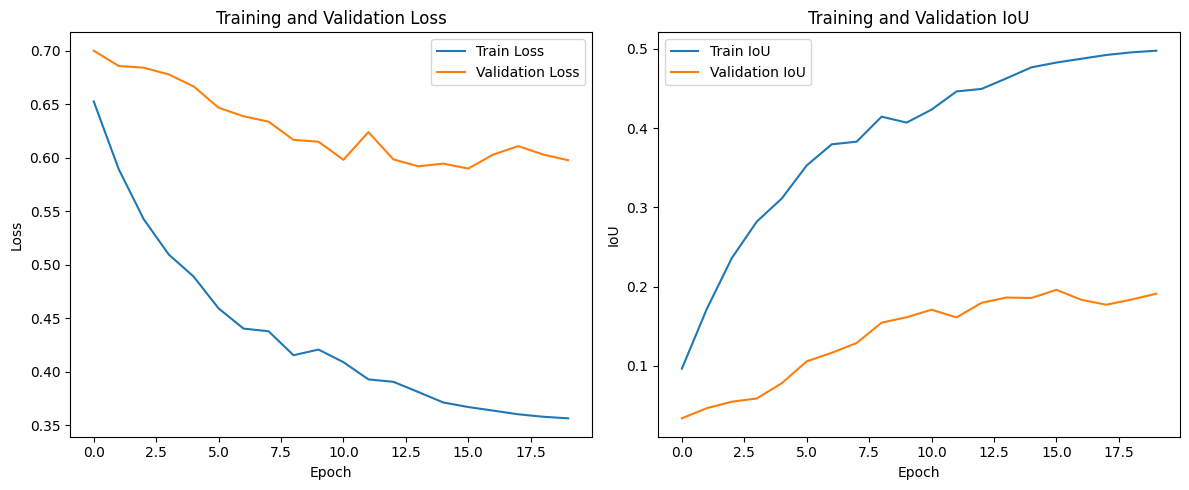

Validation: 100%|██████████| 68/68 [00:15<00:00,  4.32it/s, loss=0.598, iou=0.191]


Final Validation - Loss: 0.5979, IoU: 0.1909

Running inference on test set...



Inference:   1%|▏         | 5/386 [00:00<00:14, 26.04it/s]



Inference Results:

Image 1: f73b754cdb1ab677.jpg
Original dimensions: 1024x683
Ground truth box (normalized): [0.66651046 0.75222886 0.82257646 0.8172848 ]
Predicted box (normalized): [0.5958877  0.6974073  0.79470724 0.84160846]
IoU: 0.2736
Ground truth box (pixels): [np.float32(213.28336), np.float32(240.71323), np.float32(263.22446), np.float32(261.53113)]
Predicted box (pixels): [np.float32(190.68407), np.float32(223.17033), np.float32(254.30632), np.float32(269.3147)]

Image 2: 844adfe06e003c09.jpg
Original dimensions: 1024x768
Ground truth box (normalized): [0.5815895 0.6764191 0.6289535 0.7122051]
Predicted box (normalized): [0.5395411  0.65007824 0.62475294 0.72397596]
IoU: 0.2395
Ground truth box (pixels): [np.float32(186.10864), np.float32(216.4541), np.float32(201.26512), np.float32(227.90564)]
Predicted box (pixels): [np.float32(172.65317), np.float32(208.02504), np.float32(199.92094), np.float32(231.6723)]

Image 3: e9cd346a4a84d594.jpg
Original dimensions: 1024x791
Grou

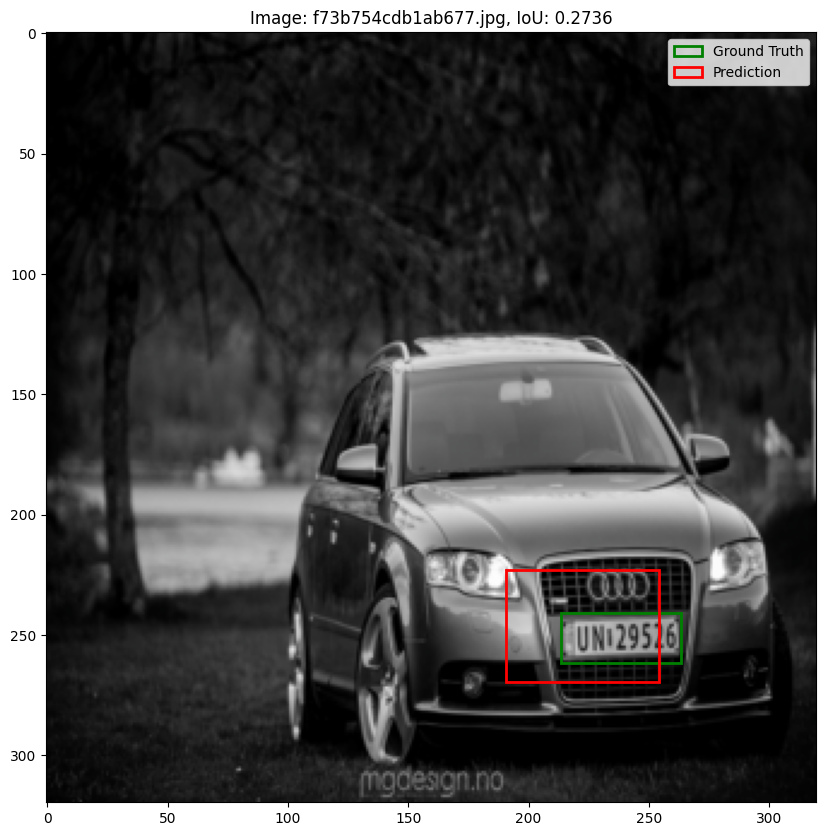

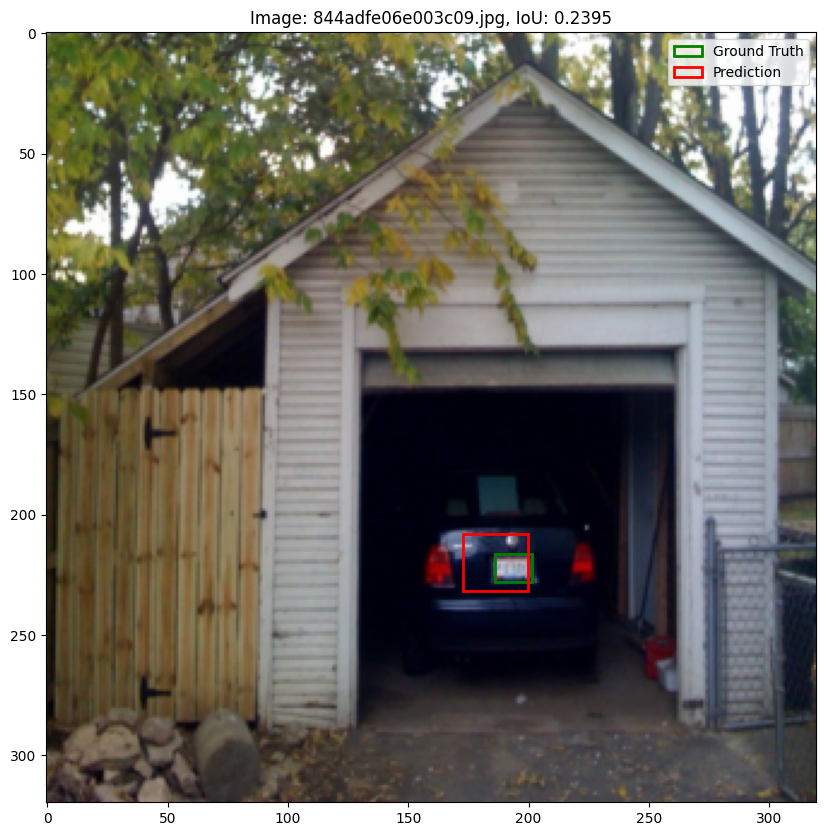

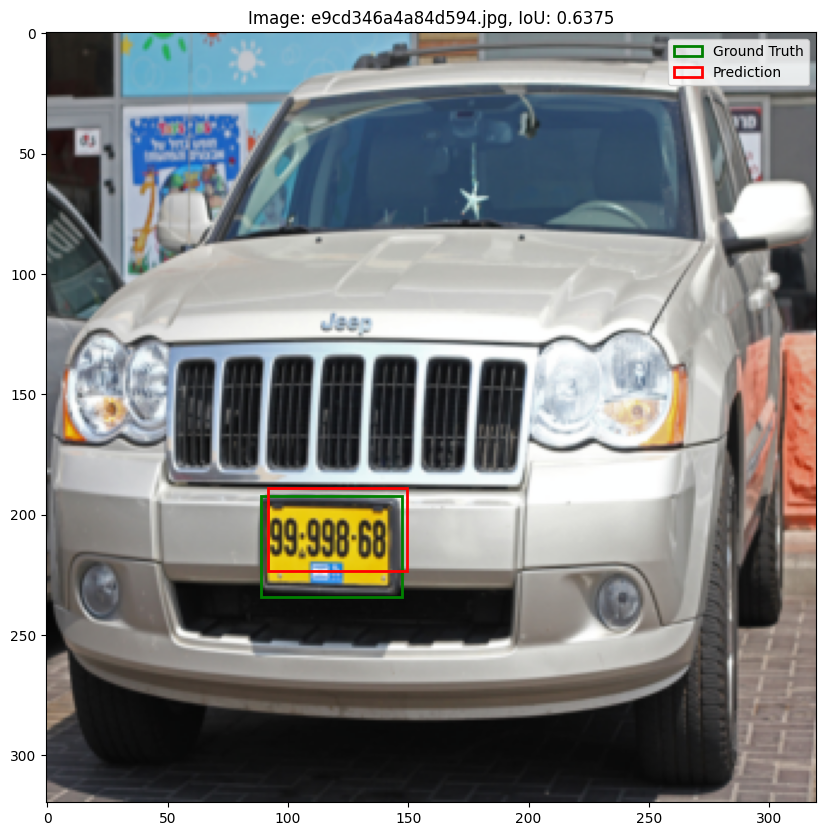

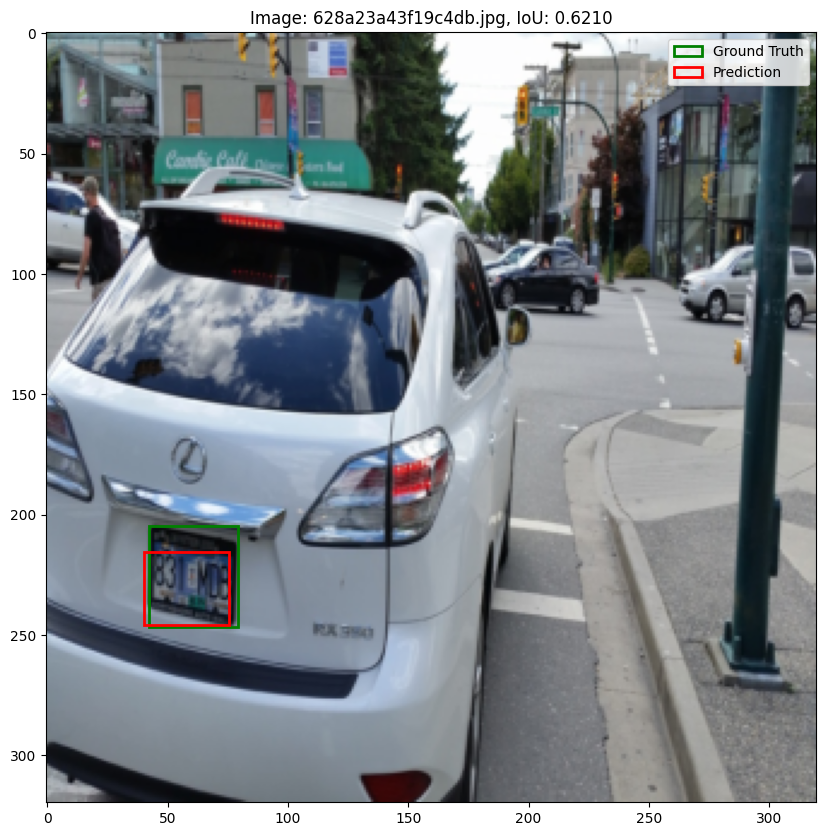

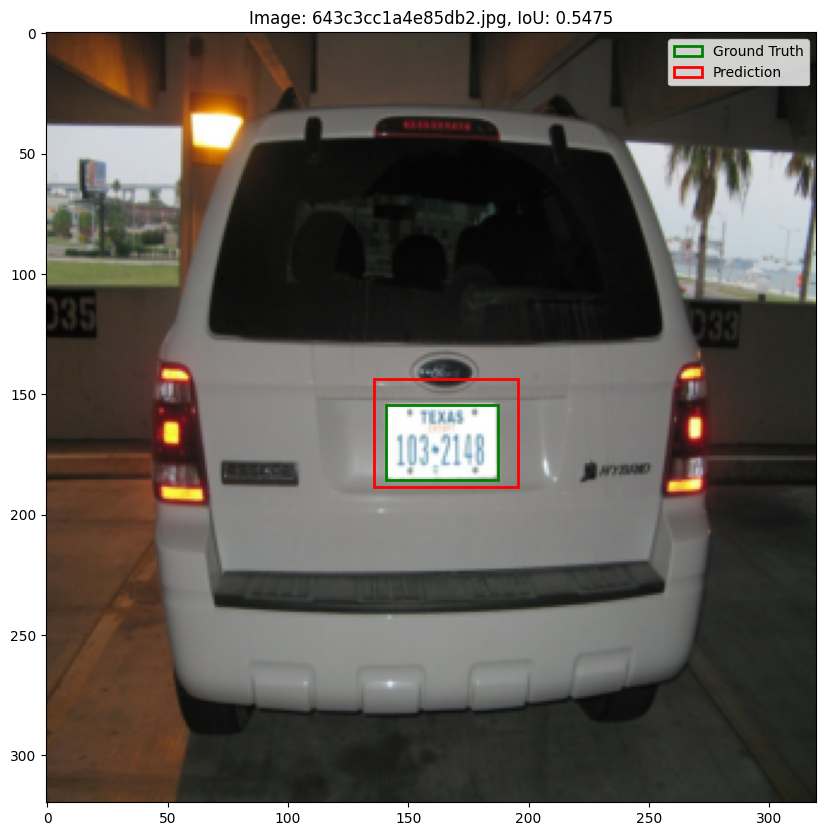


Training complete!


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  #suppress futurewarning

def main():
    print("Loading datasets...")
    train_dataset = LicensePlateDataset(train_images_path, train_labels_path, transform=transform_train, is_training=True)
    val_dataset = LicensePlateDataset(val_images_path, val_labels_path, transform=transform_val)
    test_dataset = LicensePlateDataset(test_images_path, test_labels_path, transform=transform_val)

    batch_size = 16
    num_workers = 2 if torch.cuda.is_available() else 0
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

    print("Initializing improved model...")
    model = ImprovedLicensePlateDetector().to(device)
    drive_checkpoint_dir = '/content/drive/MyDrive/DLP_Project'
    os.makedirs(drive_checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(drive_checkpoint_dir, 'best_model.pth')
    start_epoch = 0
    best_val_iou = 0.0
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    try:
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device)
 
            missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
            if missing_keys or unexpected_keys:
                print(f"Checkpoint loading: {len(missing_keys)} missing keys, {len(unexpected_keys)} unexpected keys. Proceeding with partial load.")
            else:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint.get('epoch', 0)
                best_val_iou = checkpoint.get('val_iou', 0.0)
                print(f"Model successfully loaded from {checkpoint_path} at epoch {start_epoch}")
        else:
            print(f"No checkpoint found at {checkpoint_path}. Starting training from scratch.")
    except Exception as e:
        print(f"Error loading checkpoint. Starting training from scratch.")

    model.train()

    criterion = CombinedLoss(alpha=0.7)  # Higher weight to IoU loss

    num_epochs = 20
    warmup_epochs = 2

    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            # Cosine annealing
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    scaler = torch.amp.GradScaler('cuda')

    best_model_state = None
    best_val_iou = max(best_val_iou, 0.0)

    train_losses = []
    train_ious = []
    val_losses = []
    val_ious = []

    patience = 5
    patience_counter = 0

    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Train")

        for batch_idx, (images, targets, _) in progress_bar:
            boxes = targets.squeeze(1)
            images = images.to(device)
            boxes = boxes.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, boxes)
            if torch.isnan(loss).any():
                print(f"Warning: NaN loss detected in batch {batch_idx}. Skipping batch.")
                continue

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            with torch.no_grad():
                batch_iou = calculate_iou(outputs, boxes).mean().item()
                running_iou += batch_iou

            progress_bar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'iou': running_iou / (batch_idx + 1)
            })

        epoch_loss = running_loss / len(train_loader)
        epoch_iou = running_iou / len(train_loader)
        train_losses.append(epoch_loss)
        train_ious.append(epoch_iou)

        val_loss, val_iou = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_ious.append(val_iou)

        scheduler.step()

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"  ↳ New best model saved with validation IoU: {best_val_iou:.4f}")

            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou,
                'val_loss': val_loss,
            }
            torch.save(checkpoint, os.path.join(drive_checkpoint_dir, 'best_license_plate_detector.pth'))
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_ious, label='Train IoU')
    plt.plot(val_ious, label='Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Training and Validation IoU')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(drive_checkpoint_dir, 'training_metrics.png'))
    plt.show()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    final_val_loss, final_val_iou = validate(model, val_loader, criterion)
    print(f"\nFinal Validation - Loss: {final_val_loss:.4f}, IoU: {final_val_iou:.4f}")

    print("\nRunning inference on test set...")
    results = inference(model, test_loader, num_samples=5)

    print("\nVisualizing predictions...")
    visualize_predictions(results, test_loader)

    print("\nTraining complete!")

    return model, results

if __name__ == "__main__":
    main()